In [2]:
import numpy as np
from typing import List
import random
import matplotlib.pyplot as plt


In [13]:
class WindyGridWorld:
    def __init__(self):
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.start = (3, 0)
        self.goal = (3, 7)
        self.rows = 7
        self.cols = 10

    def step(self, state: List[int], action: str):
        next_state = state.copy()
        mean_wind_effect = self.wind[state[1]]
        stochastic_variation = random.choice([-1, 0, 1])
        wind_effect = mean_wind_effect + stochastic_variation
        if action == 'up':
            next_state[0] = state[0] - 1 - wind_effect
        elif action == 'down':
            next_state[0] = state[0] + 1 - wind_effect
        elif action == 'left':
            next_state[0] = state[0] - wind_effect
            next_state[1] = state[1] - 1
        elif action == 'right':
            next_state[0] = state[0] - wind_effect
            next_state[1] = state[1] + 1
        elif action == 'up_right':
            next_state[0] = state[0] - 1 - wind_effect
            next_state[1] = state[1] + 1
        elif action == 'up_left':
            next_state[0] = state[0] - 1 - wind_effect
            next_state[1] = state[1] - 1
        elif action == 'down_right':
            next_state[0] = state[0] + 1 - wind_effect
            next_state[1] = state[1] + 1
        elif action == 'down_left':
            next_state[0] = state[0] + 1 - wind_effect
            next_state[1] = state[1] - 1

        next_state[0] = max(0, next_state[0])
        next_state[0] = min(self.rows - 1, next_state[0])
        next_state[1] = max(0, next_state[1])
        next_state[1] = min(self.cols - 1, next_state[1])

        reward = 0 if next_state == list(self.goal) else -1
        done = True if next_state == list(self.goal) else False
        return next_state, reward, done

In [14]:
class Agent:
    def __init__(self):
        self.epsilon = 0.1
        self.alpha = 0.5
        self.gamma = 1.0
        self.q_table = {}
        self.actions = ['up', 'down', 'left', 'right', 'up_right', 'up_left', 'down_right', 'down_left']

    def get_q(self, state: List[int], action: str):
        s_tuple = tuple(state)
        if s_tuple not in self.q_table:
            self.q_table[s_tuple] = [0.0] * len(self.actions)
        return self.q_table[s_tuple][self.actions.index(action)]

    def set_q(self, state: List[int], action: str, value: float):
        s_tuple = tuple(state)
        self.q_table[s_tuple][self.actions.index(action)] = value

    def get_v(self, state: List[int]):
        s_tuple = tuple(state)
        if s_tuple not in self.q_table:
            return 0.0
        else:
            q_values = np.array(self.q_table[s_tuple])
            num_actions = len(self.actions) # 动作空间大小

            # 找到最大的Q值
            max_q = np.max(q_values)

            # 找到所有使得Q值达到最大的动作的索引
            optimal_action_indices = np.where(q_values == max_q)[0]
            
            # L 是最优动作的数量
            L = len(optimal_action_indices) 
            
            state_value = 0.0
            
            # 计算每个动作的概率并累加到 V(s)
            for i, q_val in enumerate(q_values):
                if i in optimal_action_indices:
                    # 对于最优动作的概率： (1 - epsilon) / L + epsilon / num_actions
                    prob_a = (1 - self.epsilon) / L + self.epsilon / num_actions
                else:
                    # 对于非最优动作的概率： epsilon / num_actions
                    prob_a = self.epsilon / num_actions
                
                state_value += prob_a * q_val
            
            return state_value


    def choose_action(self, state: List[int]):
        if np.random.rand() < self.epsilon:
            return random.choice(self.actions)
        else:
            s_tuple = tuple(state)
            if s_tuple not in self.q_table:
                # 如果状态未见过，随机选择动作
                return random.choice(self.actions)
            else:
                current_q_value = np.array(self.q_table[s_tuple])
                action_index = np.argmax(current_q_value)
                return self.actions[action_index]

    def update_estimate(self, state: List[int], action: str, reward: int, next_state: List[int], next_action: str):
        td_error = reward + self.gamma * self.get_q(next_state, next_action) - self.get_q(state, action)
        # print(td_error)
        new_q = self.get_q(state, action) + self.alpha * td_error
        self.set_q(state, action, new_q)

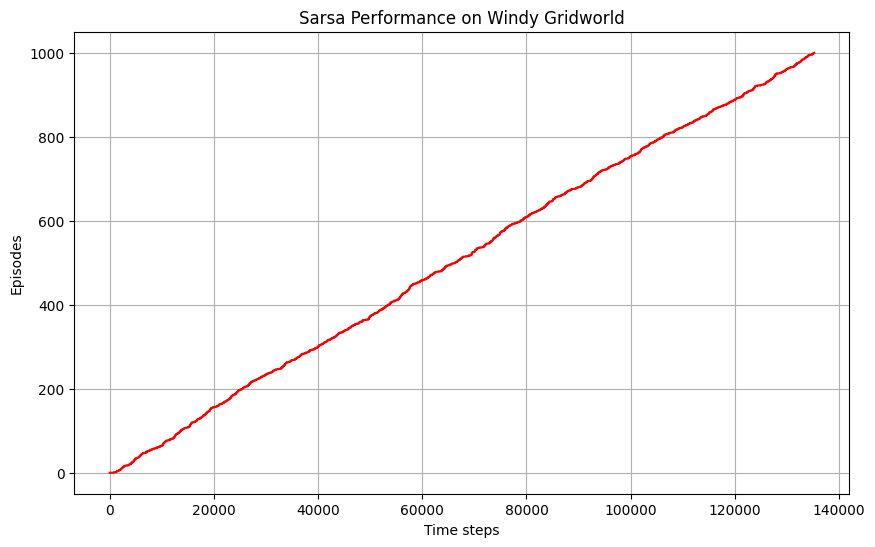

Text(0.5, 1.0, 'Last Episode Trajectory in Windy Gridworld')

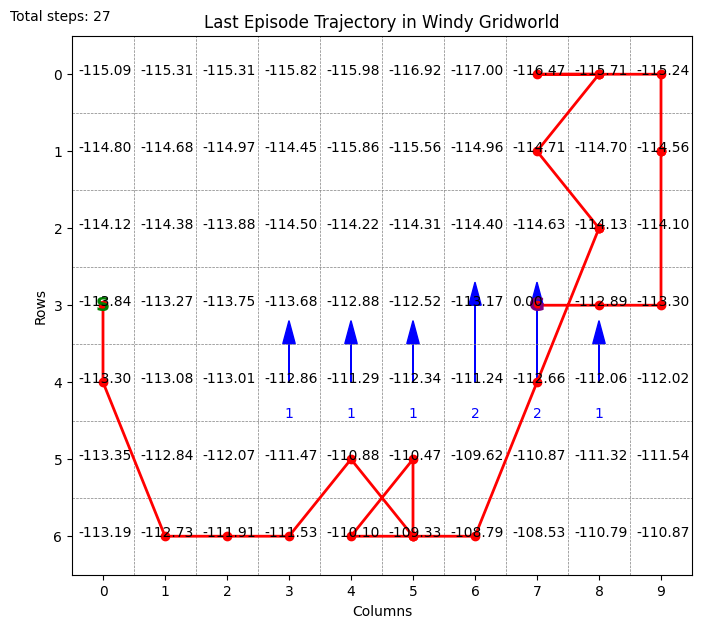

In [18]:
env = WindyGridWorld()
agent = Agent()

episode_data = []
time_step_data = []
n_episode = 0
n_steps = 0

for episode in range(1000):
    n_episode += 1
    
    state = list(env.start)

    current_episode_states = [] # 存储当前回合的状态序列
    current_episode_states.append(state) # 记录起始状态

    action = agent.choose_action(state)
    while True:
        n_steps += 1
        episode_data.append(n_episode)
        time_step_data.append(n_steps)
        f'current episode: {n_episode}, current step: {n_steps}'
        next_state, reward, done = env.step(state, action)
        current_episode_states.append(next_state)
        if done:
            break
        next_action = agent.choose_action(next_state)
        agent.update_estimate(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
        

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(time_step_data, episode_data, color='red')
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.title('Sarsa Performance on Windy Gridworld')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 7)) # 调整图表大小以适应网格
# 绘制网格线
for r in range(env.rows):
    plt.axhline(r, color='gray', linestyle='--', linewidth=0.5)
for c in range(env.cols):
    plt.axvline(c, color='gray', linestyle='--', linewidth=0.5)

# 绘制风力箭头 (简化表示)
for col_idx, wind_str in enumerate(env.wind):
    if wind_str > 0:
        # 绘制风力箭头，例如在网格中间高度
        plt.arrow(col_idx + 0.5, env.rows / 2 + 1, 0, -wind_str * 0.5, 
                    head_width=0.2, head_length=0.3, fc='blue', ec='blue')
        plt.text(col_idx + 0.5, env.rows / 2 + 1.5, str(wind_str), 
                    ha='center', va='bottom', color='blue')


# 绘制起点和终点
start_row, start_col = env.start
goal_row, goal_col = env.goal
plt.text(start_col + 0.5, start_row + 0.5, 'S', color='green', 
            fontsize=14, ha='center', va='center', fontweight='bold')
plt.text(goal_col + 0.5, goal_row + 0.5, 'G', color='purple', 
            fontsize=14, ha='center', va='center', fontweight='bold')

# 绘制轨迹
path_x = [s[1] + 0.5 for s in current_episode_states] # 列作为x坐标
path_y = [s[0] + 0.5 for s in current_episode_states] # 行作为y坐标

plt.plot(path_x, path_y, marker='o', linestyle='-', color='red', linewidth=2, markersize=6)

# 调整坐标轴范围和方向，使y轴向上增长，且原点在左上角
plt.xlim(0.0, env.cols)
plt.ylim(env.rows, 0.0) # Y轴反向，使(0,0)在左上角

plt.xticks(np.arange(0.5, env.cols + 0.5, 1), labels=np.arange(0, env.cols, 1))
plt.yticks(np.arange(0.5, env.rows + 0.5, 1), labels=np.arange(0, env.rows, 1))

plt.text(-1., -0.2, f'Total steps: {len(current_episode_states) - 1}')
for i in range(0, env.rows):
    for j in range(0, env.cols):
        v = agent.get_v((i, j))
        plt.text(j + 0.1, i + 0.5, f'{v:.2f}')

plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Last Episode Trajectory in Windy Gridworld')